In [ ]:
from timedisagg.td import TempDisagg
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import calendar
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import GridSearchCV


In [ ]:
df = pd.read_csv('Data/datewise_vertical_data.csv')
len(df)

18235

In [ ]:
sheets = pd.read_excel('Data/Media data-Sale Calendar-NPS Scores_Data.xlsx', sheet_name=None)
dfs = list(sheets.values())

monthly_df, _, _ = dfs # media, sale, nps

monthly_df.columns = monthly_df.iloc[1]
monthly_df = monthly_df[2:]
monthly_df = monthly_df.drop(columns = monthly_df.columns[0])
monthly_df = monthly_df.apply(pd.to_numeric)
monthly_df = monthly_df.fillna(0)
monthly_df['Year-Month'] = pd.to_datetime(monthly_df[['Year', 'Month']].assign(DAY=1), errors='coerce')
monthly_df['Year-Month'] = monthly_df['Year-Month'].dt.strftime('%Y-%m')
monthly_df = monthly_df.dropna(subset=['Year-Month'])
monthly_df = monthly_df.drop(columns=['Year', 'Month'])
monthly_df

1,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other,Year-Month
2,17.061775,0.215330,2.533014,7.414270,0.000933,1.327278,0.547254,5.023697,0.00,0.000000,2023-07
3,5.064306,0.006438,1.278074,1.063332,0.000006,0.129244,0.073684,2.513528,0.00,0.000000,2023-08
4,96.254380,3.879504,1.356528,62.787651,0.610292,16.379990,5.038266,6.202149,0.00,0.000000,2023-09
5,170.156297,6.144711,12.622480,84.672532,3.444075,24.371778,6.973711,31.927011,0.00,0.000000,2023-10
6,51.216220,4.220630,1.275469,14.172116,0.168633,19.561574,6.595767,5.222032,0.00,0.000000,2023-11
7,106.745312,5.397502,3.063360,56.705419,1.067307,22.503756,6.826938,11.181030,0.00,0.000000,2023-12
8,74.196000,4.380000,0.456000,4.200000,0.900000,22.900000,7.370000,4.200000,2.70,27.090000,2024-01
9,48.052000,2.586008,1.912651,11.725555,0.596771,19.892366,6.465019,4.873630,0.00,0.000000,2024-02
10,100.024621,9.300000,2.100000,41.590000,0.370000,18.437818,6.217667,5.193591,0.87,15.945545,2024-03
11,56.848241,5.205196,0.871892,24.308354,0.034876,16.514510,5.693456,4.219958,0.00,0.000000,2024-04


In [ ]:
monthly_df.columns = ['Total_Investment', 'TV', 'Digital', 'Sponsorship', 'Content_Marketing',
       'Online_marketing', 'Affiliates', 'SEM', 'Radio', 'Other',
       'Year-Month']

df['order_date'] = pd.to_datetime(df['order_date'])
df['sla'] = df['sla'] * df['units']
df = df.groupby(['order_date']).agg({
    'gmv': 'sum',
    'units': 'sum',
    'holiday': 'first',
    'sale': 'first',
    'sla': 'sum',
    'pay_day': 'first'
}).reset_index()

df['sla'] = df['sla']/df['units']
df['order_date'] = pd.to_datetime(df['order_date'])
df['Year-Month'] = df['order_date'].dt.to_period('M').astype(str)

df['units_roll3'] = df['units'].shift(1).rolling(window=3, min_periods=1).mean()
df['gmv_roll3'] = df['gmv'].shift(1).rolling(window=3, min_periods=1).mean()
df['gmv_roll7'] = df['gmv'].rolling(window=7, min_periods=1).mean()
df['units_roll7'] = df['units'].rolling(window=7, min_periods=1).mean()

df['units_roll3'] = df['units_roll3'].fillna(df['units'].mode())
df['gmv_roll3'] = df['gmv_roll3'].fillna(df['gmv'].mode())
df['units_roll7'] = df['units_roll7'].fillna(df['units'].mode())
df['gmv_roll7'] = df['gmv_roll7'].fillna(df['gmv'].mode())

In [ ]:
channels = ['TV', 'Digital', 'Sponsorship', 'Content_Marketing', 'Online_marketing', 'Affiliates', 'SEM', 'Radio', 'Other']

In [ ]:
daily_df = df.copy()

Initial XGBoost Model: RMSE = 0.05, R² = 0.28


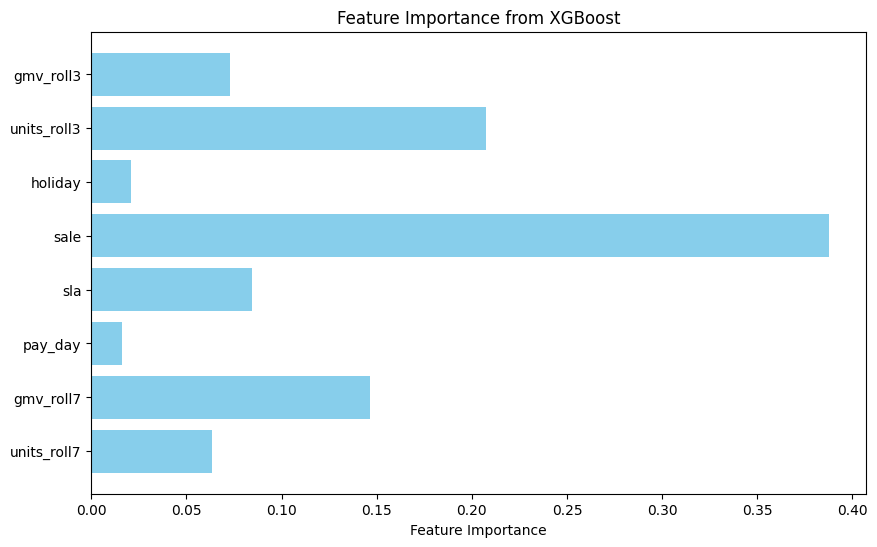

Cross-Validated RMSE: 0.24
Best Parameters: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Best RMSE from Randomized Search: 0.25
Final XGBoost Model: RMSE = 7128025.15, R² = 0.42
Updated daily_df with predicted GMV:


,order_date,gmv,predicted_gmv,predicted_gmv_normalized
0,2023-07-01,20747.0,5.233222e+05,0.000118
1,2023-07-03,568303.0,7.905346e+05,0.002608
2,2023-07-04,81821.0,1.123594e+06,0.005710
3,2023-07-05,1899.0,1.420604e+06,0.008477
4,2023-07-06,54150.0,1.470382e+06,0.008941


In [ ]:
# Define features and target
features = ['gmv_roll3', 'units_roll3', 'holiday', 'sale', 'sla', 'pay_day', 'gmv_roll7', 'units_roll7']
target = 'gmv'

# Drop rows with missing values in the target variable
daily_df = daily_df.dropna(subset=[target])

# Normalize the target variable
scaler_target = MinMaxScaler()
daily_df['gmv_normalized'] = scaler_target.fit_transform(daily_df[[target]])
target = 'gmv_normalized'

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    daily_df[features],
    daily_df[target],
    test_size=0.2,
    random_state=42
)

# Step 1: Train Initial XGBoost Model
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Predict and evaluate initial model
y_pred = xgb_model.predict(X_test)
rmse_initial = np.sqrt(mean_squared_error(y_test, y_pred))
r2_initial = r2_score(y_test, y_pred)
print(f"Initial XGBoost Model: RMSE = {rmse_initial:.2f}, R² = {r2_initial:.2f}")

# Step 2: Feature Importance Analysis
importances = xgb_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importance from XGBoost")
plt.gca().invert_yaxis()
plt.show()

# Step 3: Cross-Validation
cv_scores = cross_val_score(
    xgb_model,
    daily_df[features],
    daily_df[target],
    scoring='neg_root_mean_squared_error',
    cv=5
)
avg_rmse_cv = np.sqrt(-cv_scores.mean())
print(f"Cross-Validated RMSE: {avg_rmse_cv:.2f}")

# Step 4: Hyperparameter Tuning with RandomizedSearchCV
param_distributions = {
    'n_estimators': [300, 400, 500],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}
random_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=10,  # Number of parameter settings sampled
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_rmse = np.sqrt(-random_search.best_score_)
print("Best Parameters:", best_params)
print(f"Best RMSE from Randomized Search: {best_rmse:.2f}")

# Step 5: Retrain Final Model with Best Parameters
final_model = XGBRegressor(**best_params, random_state=42)
final_model.fit(X_train, y_train)

# Predict and evaluate final model
y_pred_final = final_model.predict(X_test)
y_test_original = scaler_target.inverse_transform(y_test.values.reshape(-1, 1)).flatten()
y_pred_original = scaler_target.inverse_transform(y_pred_final.reshape(-1, 1)).flatten()

rmse_final = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2_final = r2_score(y_test_original, y_pred_original)
print(f"Final XGBoost Model: RMSE = {rmse_final:.2f}, R² = {r2_final:.2f}")

# Step 6: Generate Predicted GMV for All Rows
daily_df['predicted_gmv'] = scaler_target.inverse_transform(final_model.predict(daily_df[features]).reshape(-1, 1)).flatten()

# Normalize the predicted GMV column using a new scaler
scaler_predicted_gmv = MinMaxScaler()
daily_df['predicted_gmv_normalized'] = scaler_predicted_gmv.fit_transform(daily_df[['predicted_gmv']])

# Display updated DataFrame
print("Updated daily_df with predicted GMV:")
display(daily_df[['order_date', 'gmv', 'predicted_gmv', 'predicted_gmv_normalized']].head())

In [ ]:
# Step 1: Balance Dataset for Temporal Disaggregation
def balance_dataset_for_timedisagg(monthly_df, daily_df, channel):
    td_data = []
    DAYS_PER_MONTH = 31  # Use 31 as maximum days per month

    months = monthly_df['Year-Month'].unique()
    for month in months:
        month_data = monthly_df[monthly_df['Year-Month'] == month]
        if month_data.empty:
            continue

        monthly_value = pd.to_numeric(month_data[channel].iloc[0], errors='coerce')
        if pd.isna(monthly_value) or monthly_value == 0:
            continue

        month_days = daily_df[daily_df['Year-Month'] == month].copy()
        if month_days.empty:
            continue

        month_days = month_days.sort_values('order_date')
        try:
            year, month_num = map(int, month.split('-'))
            _, days_in_month = calendar.monthrange(year, month_num)
        except:
            days_in_month = 31

        # Compute average value for the indicator (X)
        avg_X = month_days['X'].mean()

        for day in range(1, DAYS_PER_MONTH + 1):
            day_row = {
                'index': month,
                'grain': day,
                'y': float(monthly_value)  # Monthly value to disaggregate
            }

            if day <= days_in_month and day in month_days['order_date'].dt.day.values:
                # Use actual X value if available
                X_value = month_days.loc[month_days['order_date'].dt.day == day, 'X'].iloc[0]
            else:
                # Use average X value if not available
                X_value = avg_X

            # Handle NaNs by falling back to the average
            if pd.isna(X_value):
                X_value = avg_X if not pd.isna(avg_X) else 0.0

            # Add the X column
            day_row['X'] = float(X_value)

            td_data.append(day_row)

    return pd.DataFrame(td_data)


# Step 2: Apply Disaggregation to Original Days
def apply_disaggregation_to_original_days(disagg_result, daily_df, channel):
    result_df = daily_df.copy()
    result_df[channel] = 0.0

    # Identify the column containing disaggregated values (e.g., 'y_hat' or 'value')
    value_col = None
    for col in disagg_result.columns:
        if col.startswith(('y_hat', 'value')):
            value_col = col
            break

    if value_col is None:
        print(f"Warning: Could not find value column in disagg_result. Columns: {disagg_result.columns}")
        return result_df

    for month in result_df['Year-Month'].unique():
        month_mask_daily = result_df['Year-Month'] == month
        month_mask_disagg = disagg_result['index'] == month
        if not month_mask_disagg.any():
            continue

        for _, day_row in result_df[month_mask_daily].iterrows():
            day_of_month = day_row['order_date'].day
            day_mask = disagg_result['grain'] == day_of_month
            if month_mask_disagg.any() and day_mask.any():
                value = disagg_result.loc[month_mask_disagg & day_mask, value_col].iloc[0]

                # Ensure non-negativity
                value = max(0.0, value)

                result_df.loc[result_df['order_date'] == day_row['order_date'], channel] = value

    return result_df


# Step 3: Rebalance Monthly Totals After Clipping
def rebalance_monthly_totals(channel_result, monthly_df, channel):
    """
    Rebalances the monthly totals after enforcing non-negativity.
    """
    # Calculate the current monthly sums
    current_monthly_sums = channel_result.groupby('Year-Month')[channel].sum()

    # Iterate over each month and adjust the daily values
    for month in current_monthly_sums.index:
        monthly_value = monthly_df.loc[monthly_df['Year-Month'] == month, channel].iloc[0]
        current_sum = current_monthly_sums[month]

        if current_sum > 0 and monthly_value > 0:
            # Calculate the scaling factor
            scale_factor = monthly_value / current_sum

            # Scale the daily values proportionally
            month_mask = channel_result['Year-Month'] == month
            channel_result.loc[month_mask, channel] *= scale_factor

    return channel_result


# Step 4: Perform Temporal Disaggregation with Balanced Data
def timedisagg_with_balanced_data(monthly_df, daily_df, channels):
    results = daily_df[['order_date', 'Year-Month']].copy()

    for channel in channels:
        print(f"Processing channel: {channel}")
        td_data = balance_dataset_for_timedisagg(monthly_df, daily_df, channel)

        td_obj = TempDisagg(conversion="sum", method="litterman-maxlog")
        disagg_result = td_obj(td_data)


        channel_result = apply_disaggregation_to_original_days(disagg_result, daily_df, channel)

        # Rebalance the monthly totals after enforcing non-negativity
        channel_result = rebalance_monthly_totals(channel_result, monthly_df, channel)

        results[channel] = channel_result[channel]

    return results


# Step 5: Validate Results
def validate_results(results, monthly_df, channels):
    validation = []
    monthly_sums = results.groupby('Year-Month')[channels].sum()

    # Check for negative values
    if (results[channels] < 0).any().any():
        print("Warning: Negative values found in the disaggregated results.")

    for _, month_row in monthly_df.iterrows():
        month = month_row['Year-Month']
        if month not in monthly_sums.index:
            continue

        row = {}
        for channel in channels:
            orig_channel = month_row[channel]
            disagg_channel = monthly_sums.loc[month, channel]
            row[f'Original_{channel}'] = orig_channel
            row[f'Disaggregated_{channel}'] = disagg_channel
            row[f'Difference_{channel}'] = orig_channel - disagg_channel
            row[f'Diff_%_{channel}'] = ((orig_channel - disagg_channel) / orig_channel * 100) if orig_channel != 0 else 0
        validation.append(row)

    return pd.DataFrame(validation)


# Step 6: Run the Full Pipeline
def run_disaggregation(monthly_df, daily_df, channels):
    print("Starting disaggregation with balanced data using Chow-Lin method...")

    # Ensure proper formatting
    daily_df = daily_df.copy()
    monthly_df = monthly_df.copy()

    daily_df['order_date'] = pd.to_datetime(daily_df['order_date'])
    if 'Year-Month' not in daily_df.columns:
        daily_df['Year-Month'] = daily_df['order_date'].dt.strftime('%Y-%m')

    if 'Year-Month' not in monthly_df.columns:
        raise ValueError("monthly_df must have a 'Year-Month' column")

    # Rename predicted_gmv to X and normalize it
    daily_df['X'] = daily_df['predicted_gmv']
    scaler = MinMaxScaler()
    daily_df['X'] = scaler.fit_transform(daily_df[['X']].fillna(0))

    # Perform temporal disaggregation
    results = timedisagg_with_balanced_data(monthly_df, daily_df, channels)
    validation = validate_results(results, monthly_df, channels)

    print("Disaggregation complete!")
    return results, validation


# Example Usage

# Define the channels to disaggregate
channels = [
    'TV', 'Digital', 'Sponsorship', 'Content_Marketing',
    'Online_marketing', 'Affiliates', 'SEM', 'Radio', 'Other'
]

# Run the disaggregation
results, validation = run_disaggregation(monthly_df, daily_df, channels=channels)

# Display results
print("Disaggregated Results:")
display(results.head())

print("Validation Results:")
display(validation.head())

Starting disaggregation with balanced data using Chow-Lin method...
Processing channel: TV
Processing channel: Digital
Processing channel: Sponsorship
Processing channel: Content_Marketing
Processing channel: Online_marketing
Processing channel: Affiliates
Processing channel: SEM
Processing channel: Radio
Processing channel: Other
Disaggregation complete!
Disaggregated Results:


,order_date,Year-Month,TV,Digital,Sponsorship,Content_Marketing,Online_marketing,Affiliates,SEM,Radio,Other
0,2023-07-01,2023-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2023-07-03,2023-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023-07-04,2023-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-07-05,2023-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023-07-06,2023-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Validation Results:


,Original_TV,Disaggregated_TV,Difference_TV,Diff_%_TV,Original_Digital,Disaggregated_Digital,Difference_Digital,Diff_%_Digital,Original_Sponsorship,Disaggregated_Sponsorship,Difference_Sponsorship,Diff_%_Sponsorship,Original_Content_Marketing,Disaggregated_Content_Marketing,Difference_Content_Marketing,Diff_%_Content_Marketing,Original_Online_marketing,Disaggregated_Online_marketing,Difference_Online_marketing,Diff_%_Online_marketing,Original_Affiliates,Disaggregated_Affiliates,Difference_Affiliates,Diff_%_Affiliates,Original_SEM,Disaggregated_SEM,Difference_SEM,Diff_%_SEM,Original_Radio,Disaggregated_Radio,Difference_Radio,Diff_%_Radio,Original_Other,Disaggregated_Other,Difference_Other,Diff_%_Other
0,0.215330,0.215330,0.000000e+00,0.000000e+00,2.533014,2.533014,0.000000e+00,0.000000e+00,7.414270,7.414270,-8.881784e-16,-1.197931e-14,0.000933,0.000933,-1.084202e-19,-1.162188e-14,1.327278,1.327278,0.000000e+00,0.000000e+00,0.547254,0.547254,0.000000e+00,0.000000e+00,5.023697,5.023697,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.006438,0.006438,0.000000e+00,0.000000e+00,1.278074,1.278074,0.000000e+00,0.000000e+00,1.063332,1.063332,0.000000e+00,0.000000e+00,0.000006,0.000006,0.000000e+00,0.000000e+00,0.129244,0.129244,0.000000e+00,0.000000e+00,0.073684,0.073684,0.000000e+00,0.000000e+00,2.513528,2.513528,4.440892e-16,1.766796e-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.879504,3.879504,4.440892e-16,1.144706e-14,1.356528,1.356528,0.000000e+00,0.000000e+00,62.787651,62.787651,-7.105427e-15,-1.131660e-14,0.610292,0.610292,0.000000e+00,0.000000e+00,16.379990,16.379990,0.000000e+00,0.000000e+00,5.038266,5.038266,-8.881784e-16,-1.762865e-14,6.202149,6.202149,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.144711,6.144711,0.000000e+00,0.000000e+00,12.622480,12.622480,1.776357e-15,1.407296e-14,84.672532,84.672532,0.000000e+00,0.000000e+00,3.444075,3.444075,0.000000e+00,0.000000e+00,24.371778,24.371778,-3.552714e-15,-1.457716e-14,6.973711,6.973711,-8.881784e-16,-1.273609e-14,31.927011,31.927011,-3.552714e-15,-1.112761e-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.220630,4.220630,0.000000e+00,0.000000e+00,1.275469,1.275469,0.000000e+00,0.000000e+00,14.172116,14.172116,0.000000e+00,0.000000e+00,0.168633,0.168633,2.775558e-17,1.645914e-14,19.561574,19.561574,0.000000e+00,0.000000e+00,6.595767,6.595767,0.000000e+00,0.000000e+00,5.222032,5.222032,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
results_df = pd.merge(daily_df, results, on=['order_date', 'Year-Month'], how='left')